#Template Testing with Machine Learning Techniques Using a Public Database of Diabetes Patients

In [93]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score,f1_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

from multiprocessing import process
import csv
from sklearn import tree



filterwarnings('ignore')

#Processing Class

In [94]:
#Class with functions to imput informations, convert types, etc.
class processing_data:
  def __init__(self,base,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, X, str_var):
        '''str type to float type
        X = Dataset
        str_var = string variable'''
        for column in str_var:
                try:
                    # Attempt to convert the column to float
                    # If the column is not already of type object (string),
                    # convert it first before applying string operations.
                    X[column] = X[column].astype(str).str.replace(',', '.').astype(float) # Use X instead of self.base
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to float. Skipping...")

        return X


  def int_values(self, X, str_var):
        '''str type to int type
        X = Dataset
        str_var = string variable'''
        for column in str_var:
                try:
                    # Attempt to convert the column to int
                    #X[column] = X[column].astype(int)
                    X[column]=pd.to_numeric(X[column], errors='coerce').astype(int) #changed column to X[column]
                except ValueError:
                    # If conversion fails, print a message and skip the column
                    print(f"Column '{column}' could not be converted to int. Skipping...")

        return X


  #if my target is a text I transform in dummy value
  #def target_variable(self,X,variavel):
  #  keys = list(self.base[variavel].unique())
  #  my_dict = {}

 #   for i, key in enumerate(keys):
 #     my_dict[key] = i
 #   self.base[variavel] = self.base[variavel].map(my_dict)
 #   return self.base,my_dict

  def target_variable(self,X,variavel,target, multiclass):
    '''convert the variable target
        X = Dataset
        variavel = column name
        target = information to mark
        multiclass = type of classification, binary or multiclass'''
    if multiclass == False:
      self.base[variavel] = np.where(self.base[variavel]==target, 1, 0)
      return self.base
    else:
      keys = list(self.base[variavel].unique())
      my_dict = {}

      for i, key in enumerate(keys):
       my_dict[key] = i
      self.base[variavel] = self.base[variavel].map(my_dict)
      #with open('list_variables_markers.txt', 'w') as file:
      # file.write(my_dict)

      # open file for writing, "w" is writing
      w = csv.writer(open("output.csv", "w"))
      # loop over dictionary keys and values
      for key, val in my_dict.items():
      # write every key and value to file
        w.writerow([key, val])
      return self.base


  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      '''Convert str variable in dummies
        X= Dataset
        dummies= list of variables to convert'''
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X,variavel):
    '''Normalize the data
        X= Dataset
        variavel= column with the target'''
    #Normalize the data
    column_to_move = X.pop(variavel)
    X[variavel] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        '''Imput Missing Values
           X = Dataset
           type_method = metric to fill missing data ex: mean'''
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            # Reshape the output of fit_transform to match the number of columns
            imputed_data = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])
            # Create a DataFrame with the imputed values and correct columns
            #Instead of using X_df.columns[missing_cols_indices] I use X_df.columns[missing_cols_indices].to_list() for creating the dataframe
            imputed_df = pd.DataFrame(imputed_data, columns=X_df.columns[missing_cols_indices].to_list(), index=X_df.index) # Changed this line
            # Update the original DataFrame with the imputed values
            X_df.update(imputed_df)

        return X_df

#Models Class Multclass

In [95]:
class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()
    self.l_encode = LabelEncoder()
    self.l_encode.fit(np.unique(y))

  def neuro_model_multiclass(self):
    ''' Neuro Network Model'''
    num_neu= len(self.Lista_variaveis)
    ocult_neu=int((num_neu*(2/3))+2)
    # Get the number of unique classes in the target variable
    num_classes = self.y.shape[1]  # Assuming self.y is one-hot encoded
    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              # Change the output layer to have num_classes units
                              tf.keras.layers.Dense(num_classes, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro

  def tree_and_random_forest(self):
    '''Decission Tree Model'''
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameter to criterion',clf.best_params_['criterion'])
      print('Best Parameter to max_depth',clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      '''Random Forest Model'''
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameter to n_estimators',clf_rf.best_params_['n_estimators'])
      print('Best Parameter to max_depth',clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):
    '''KNN Model'''
    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameter to n_neighbors',knn.best_params_['n_neighbors'])
    print('Best Parameter to p',knn.best_params_['p'])
    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f

  def models_metrics_neuro_multiclass(self, model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test):
    '''Model Metric Calculation
       Model= fitted model
       Xtrain
       ytrain
       Xtest
       ytest
       l_enconte_train
       l_enconte_test'''
    # Fit the model
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)

    pred = model.predict(Xtest)
    pred_ = np.argmax(pred, axis=1) # Get the predicted class labels directly from 'pred'
    pred_ = l_encode_test.inverse_transform(pred_) # Use the encoder from 'encode_target'
    true_y =l_encode_test.inverse_transform(np.argmax(ytest, axis=1)) # Correctly decode ytest

    scores = model.evaluate(Xtest, ytest)
    print(f'Test Loss: {scores[0]}')
    print(f'Test Accuracy: {scores[1]}')
    print('\n')
    f1 = f1_score(pred_, true_y, average="weighted")
    print(f'F1 Score: {f1}')
    print('\n')
    recall = recall_score(pred_, true_y, average="weighted")
    print(f'Recall Score: {recall}')
    print('\n')

    # Calculate permutation feature importance using the scoring function
    result = permutation_importance(
        model, Xtest, true_y, n_repeats=10, random_state=0, scoring=self.scoring_fn_multclass
    )
    # Create a DataFrame to store the results
    feature_importances = pd.DataFrame(
        {
            "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
            "importance": result.importances_mean,
        }
    ).sort_values("importance", ascending=False)


    print('\n',feature_importances)

    print('Confussion Matrix')
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(true_y, pred_))
    cmp.plot(ax=ax,cmap='inferno')
    plt.show()

  def scoring_fn_multclass(self, model, X, y):
    '''Scoring MultClass Model
       X= Dataset array
       y= Target array'''
    y_pred = model.predict(X, verbose=0)  # Get predicted probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted classes

    # Check if y is already in the correct shape
    if y.ndim == 2 and y.shape[1] > 1:  # If y is one-hot encoded
        y_true_classes = np.argmax(y, axis=1)
    else:  # If y is not one-hot encoded
        y_true_classes = y  # or use your desired method to get true classes

    return accuracy_score(y_true_classes, y_pred_classes)

  def metrics_class(self,model, Xtrain, ytrain, Xtest, ytest,type_model):
     '''Metrics to Generic MultiClass Models
       Model= fitted model
       Xtrain
       ytrain
       Xtest
       ytest
       type_model = Run a specific model for exemplo Random Forest, KNN, etc.'''
     if type_model =='Decission Tree' or type_model =='Random Forest':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        recall = recall_score(model.predict(Xtest), ytest, average="weighted")
        print("\nRecall Score:{:.2%}".format(recall))
        print('\n')
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax,cmap = 'inferno')
        plt.show()
        print('\n Feature Importance')
        feature_importances = pd.DataFrame(model.feature_importances_,
                                                  index =self.Lista_variaveis,
                                                    columns=['importance']).sort_values('importance',ascending=False)
        print(feature_importances.count())
        feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
        graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )
        if type_model =='Decission Tree':
          tree.plot_tree(model.fit(Xtrain,ytrain))
        return

     elif type_model == 'KNN':
        model.fit(Xtrain, ytrain)
        model_acc = accuracy_score(ytest, model.predict(Xtest))
        print("\nModel Accuracy: {:.2%}".format(model_acc))
        f1 = f1_score(ytest, model.predict(Xtest), average="weighted")
        print("\nF1 Score: {:.2%}".format(f1))
        recall = recall_score(model.predict(Xtest), ytest, average="weighted")
        print("\nRecall Score:{:.2%}".format(recall))
        print('\n')
        print('\nConfussion Matrix')
        fig, ax = plt.subplots(figsize=(10, 10))
        cmp = ConfusionMatrixDisplay(confusion_matrix(ytest, model.predict(Xtest)))
        cmp.plot(ax=ax, cmap='inferno')
        plt.show()
        print('\n KNN model does not have feature importance') # Print message instead of accessing feature_importances_
        return
     else:
        print('Model not found, Please Try Again With the Correct Model Type')

#Application

In [ ]:
#Dataset =pd.read_csv ("brca_tcga_pub_clinical_data.tsv", sep = '\t') # pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')


In [96]:
#Load Dataset
Dataset=pd.read_csv('Dataset of Diabetes Miss Data.csv',sep=';')

In [ ]:
#Check the Dataset
Dataset.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62.0,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46.0,4.9,NaN,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46.0,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46.0,4.9,4.9,1.0,0.8,2.0,NaN,21.0,N


In [ ]:
#Check some informations about my Dataset
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         999 non-null    float64
 6   HbA1c      1000 non-null   float64
 7   Chol       996 non-null    float64
 8   TG         998 non-null    float64
 9   HDL        998 non-null    float64
 10  LDL        998 non-null    float64
 11  VLDL       996 non-null    float64
 12  BMI        999 non-null    float64
 13  CLASS      1000 non-null   object 
dtypes: float64(9), int64(3), object(2)
memory usage: 109.5+ KB


#Some Grafics Checks

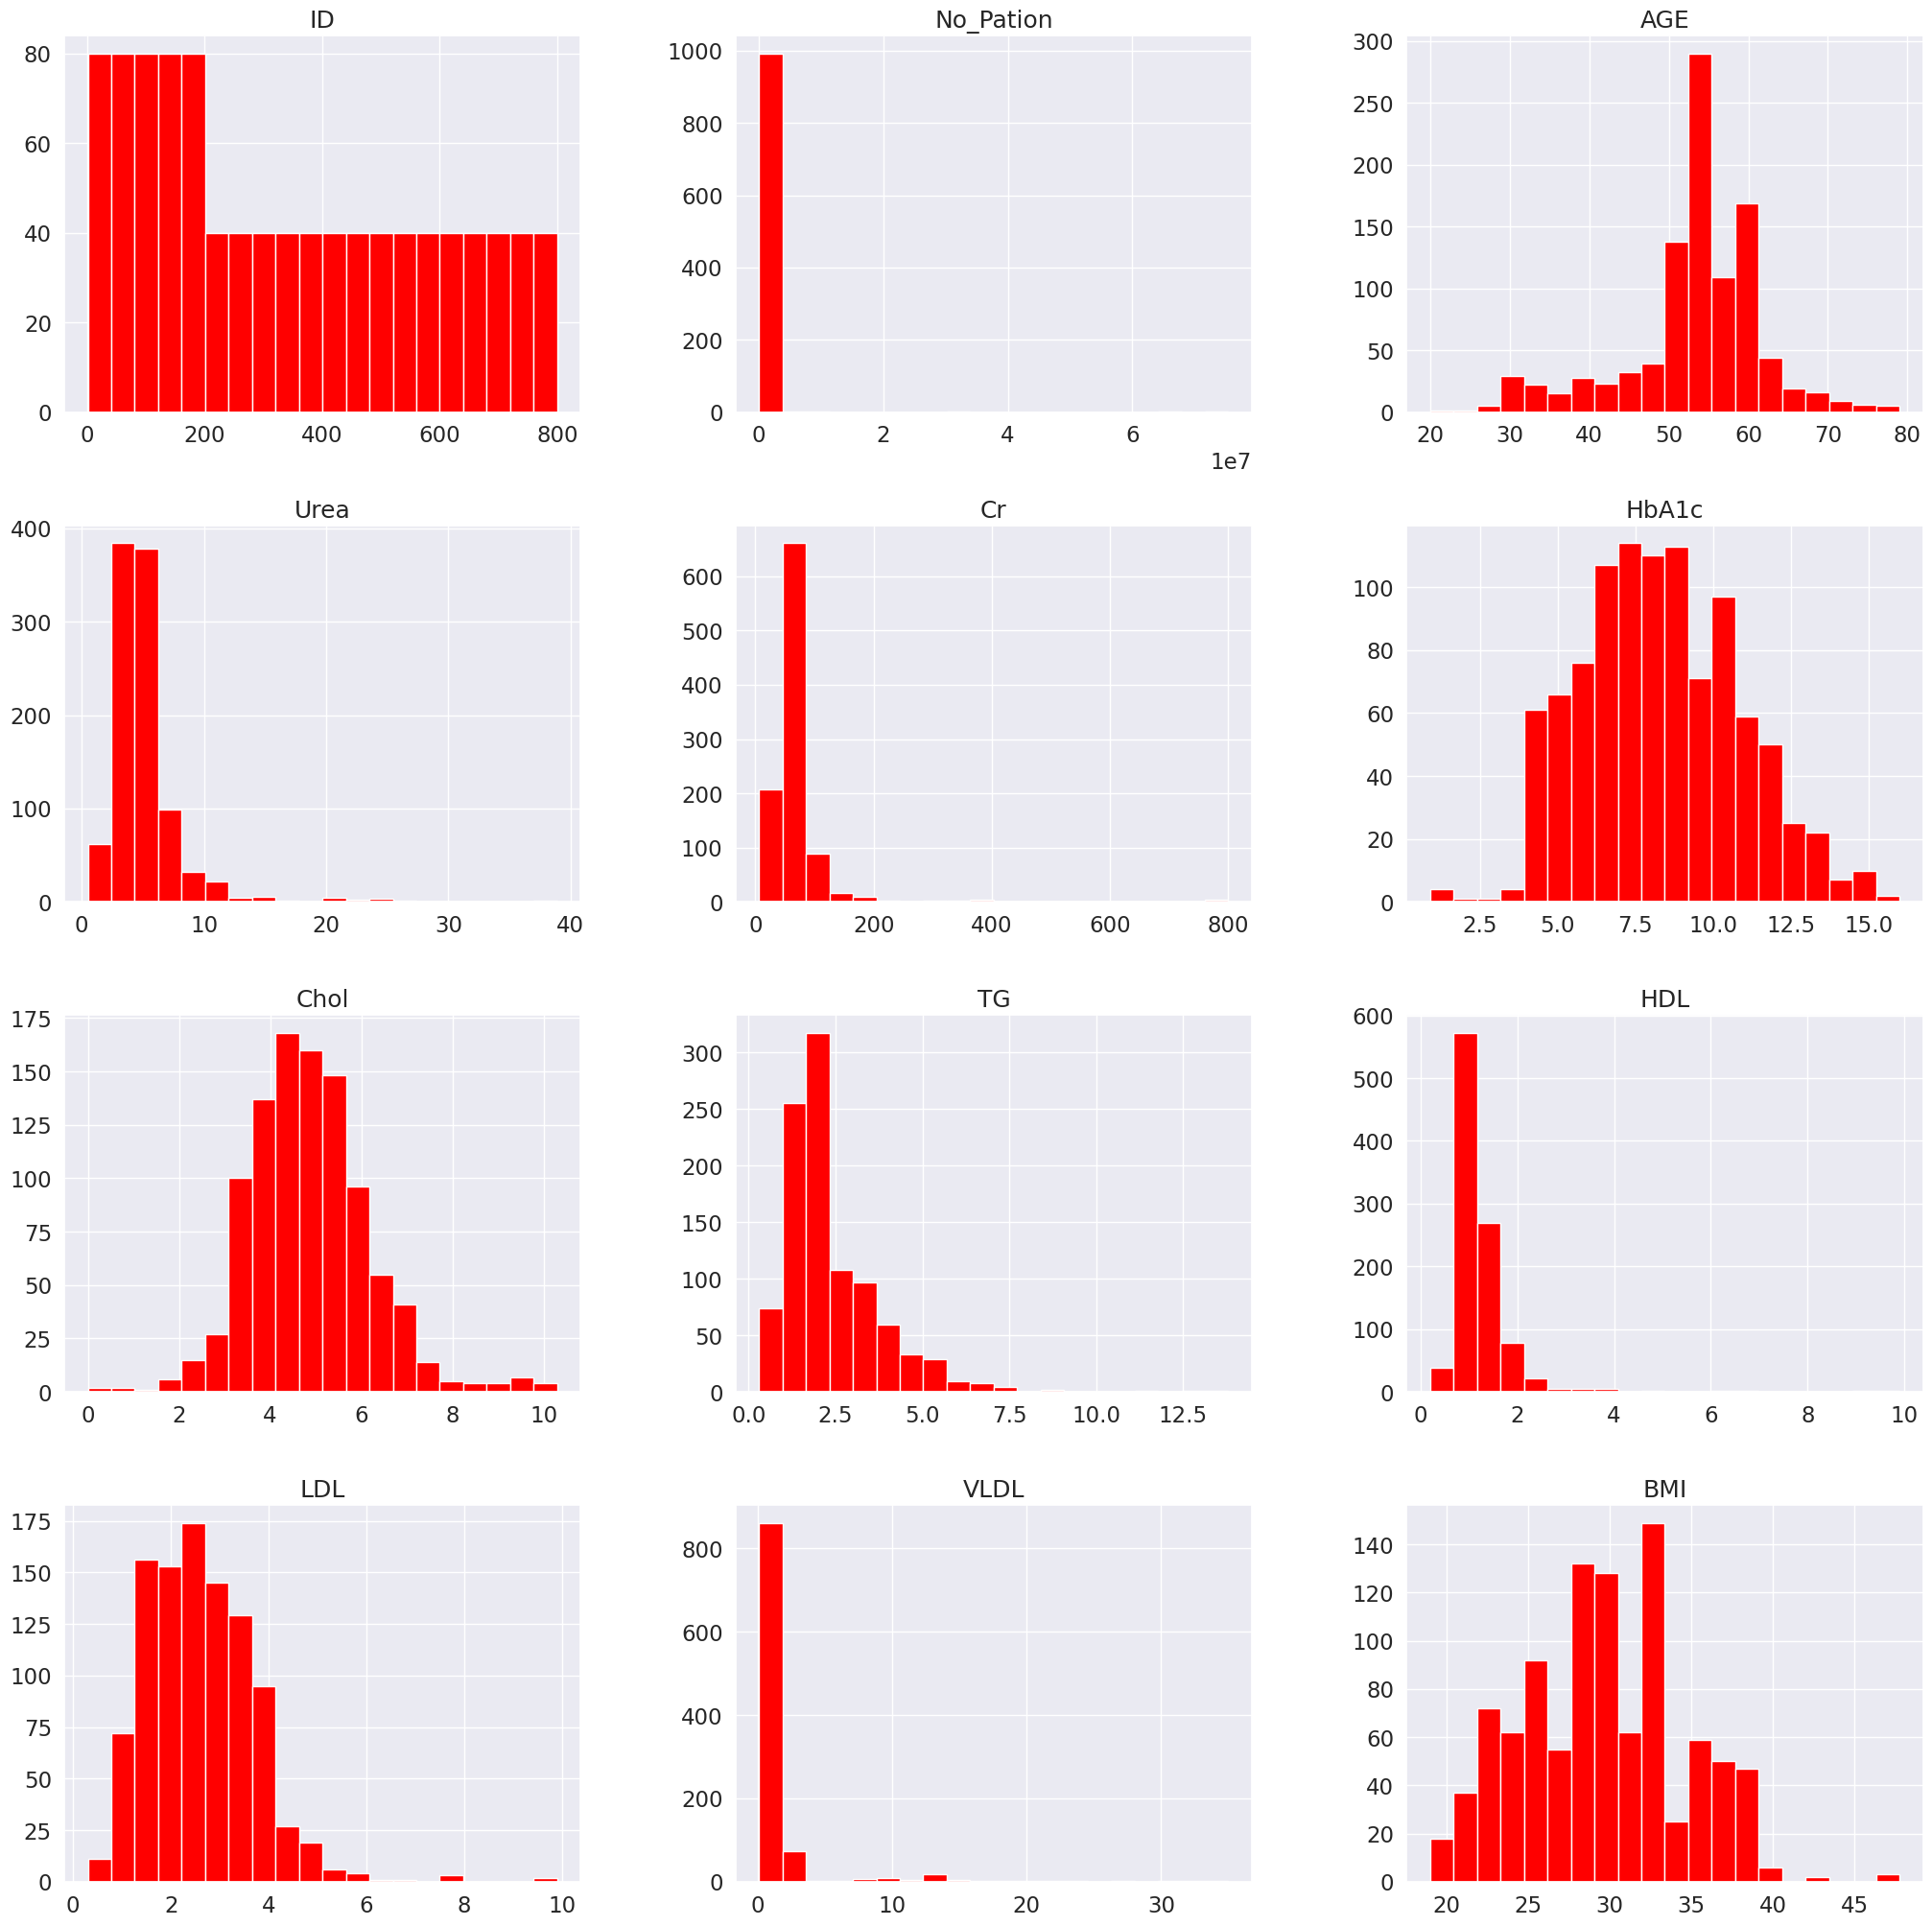

In [ ]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)})
eixo=Dataset.hist(bins=20,color='red')

<Axes: xlabel='Gender'>

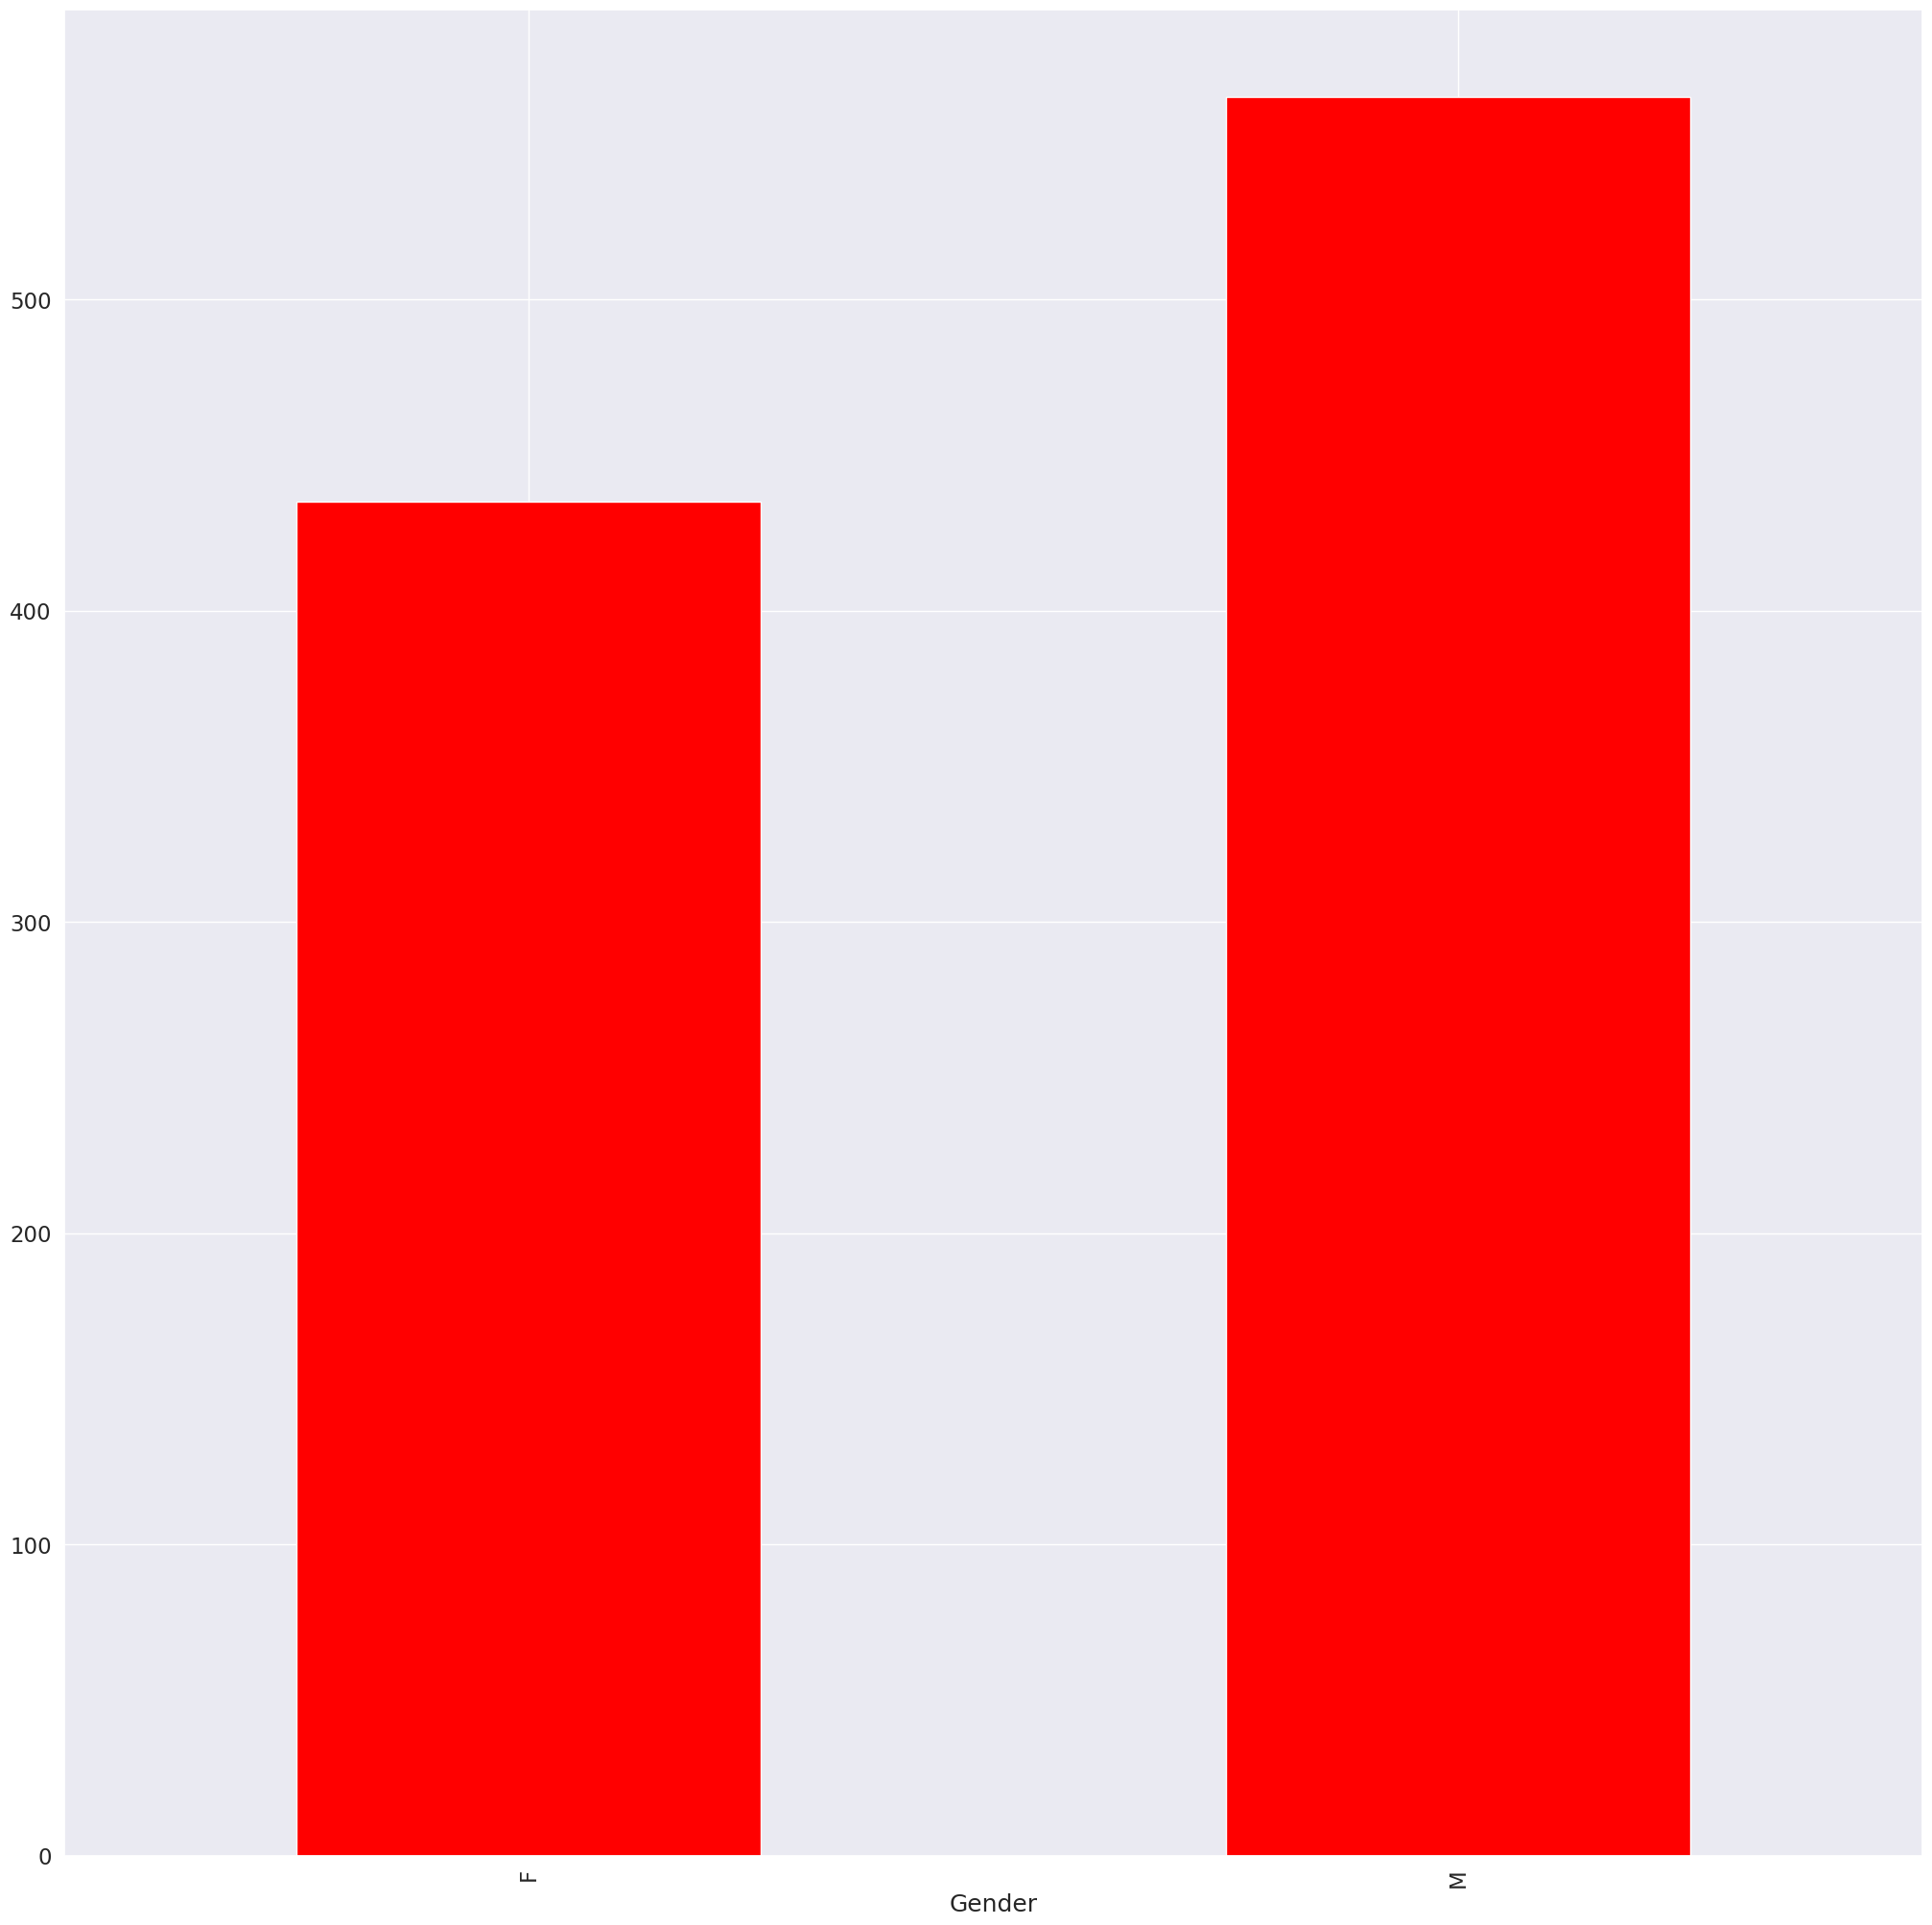

In [97]:
Dataset.Gender.value_counts().sort_values().plot(kind='bar',color='red')

In [ ]:
#Verify if I have columns wiht more than 10% missing values
percent_missing=num = (Dataset.isna().sum()/len(Dataset))*100
print(percent_missing[percent_missing > 10].index)

Index([], dtype='object')


#Variable Processing

In [98]:
list_to_drop=['ID','No_Pation']
#list_to_drop_percentage=percent_missing[percent_missing > 20].index
#Dataset.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset.drop(list_to_drop,axis=1,inplace=True)

processor = processing_data(base=Dataset.copy())
variavel='CLASS'
target='Y'
type_method='mean'
dummies=list(Dataset.select_dtypes(include=['object']).columns)
dummies.remove('CLASS')
#var_int=['Tumor Purity']
multiclass=True
#str_var=['hg','ap']

In [ ]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  1000 non-null   object 
 1   AGE     1000 non-null   int64  
 2   Urea    1000 non-null   float64
 3   Cr      999 non-null    float64
 4   HbA1c   1000 non-null   float64
 5   Chol    996 non-null    float64
 6   TG      998 non-null    float64
 7   HDL     998 non-null    float64
 8   LDL     998 non-null    float64
 9   VLDL    996 non-null    float64
 10  BMI     999 non-null    float64
 11  CLASS   1000 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 93.9+ KB


In [99]:
#Using pipelines we can apply modification in my data, to a better use in my model
main_pipeline=Pipeline([
                        #('int_values', FunctionTransformer(processor.int_values,
                        #                    kw_args={'str_var': var_int},
                        #                    validate=False)),
                        #('float_values', FunctionTransformer(processor.float_values,kw_args={'str_var': str_var},
                        #                                     validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),
                        ])

# Fit and transform the data using the pipeline
transformed_data = main_pipeline.fit_transform(Dataset)
X=processor.impute_values(transformed_data,type_method)
X,y,Lista_variaveis=processor.normalize_df(X,variavel)

#Check Metrics

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

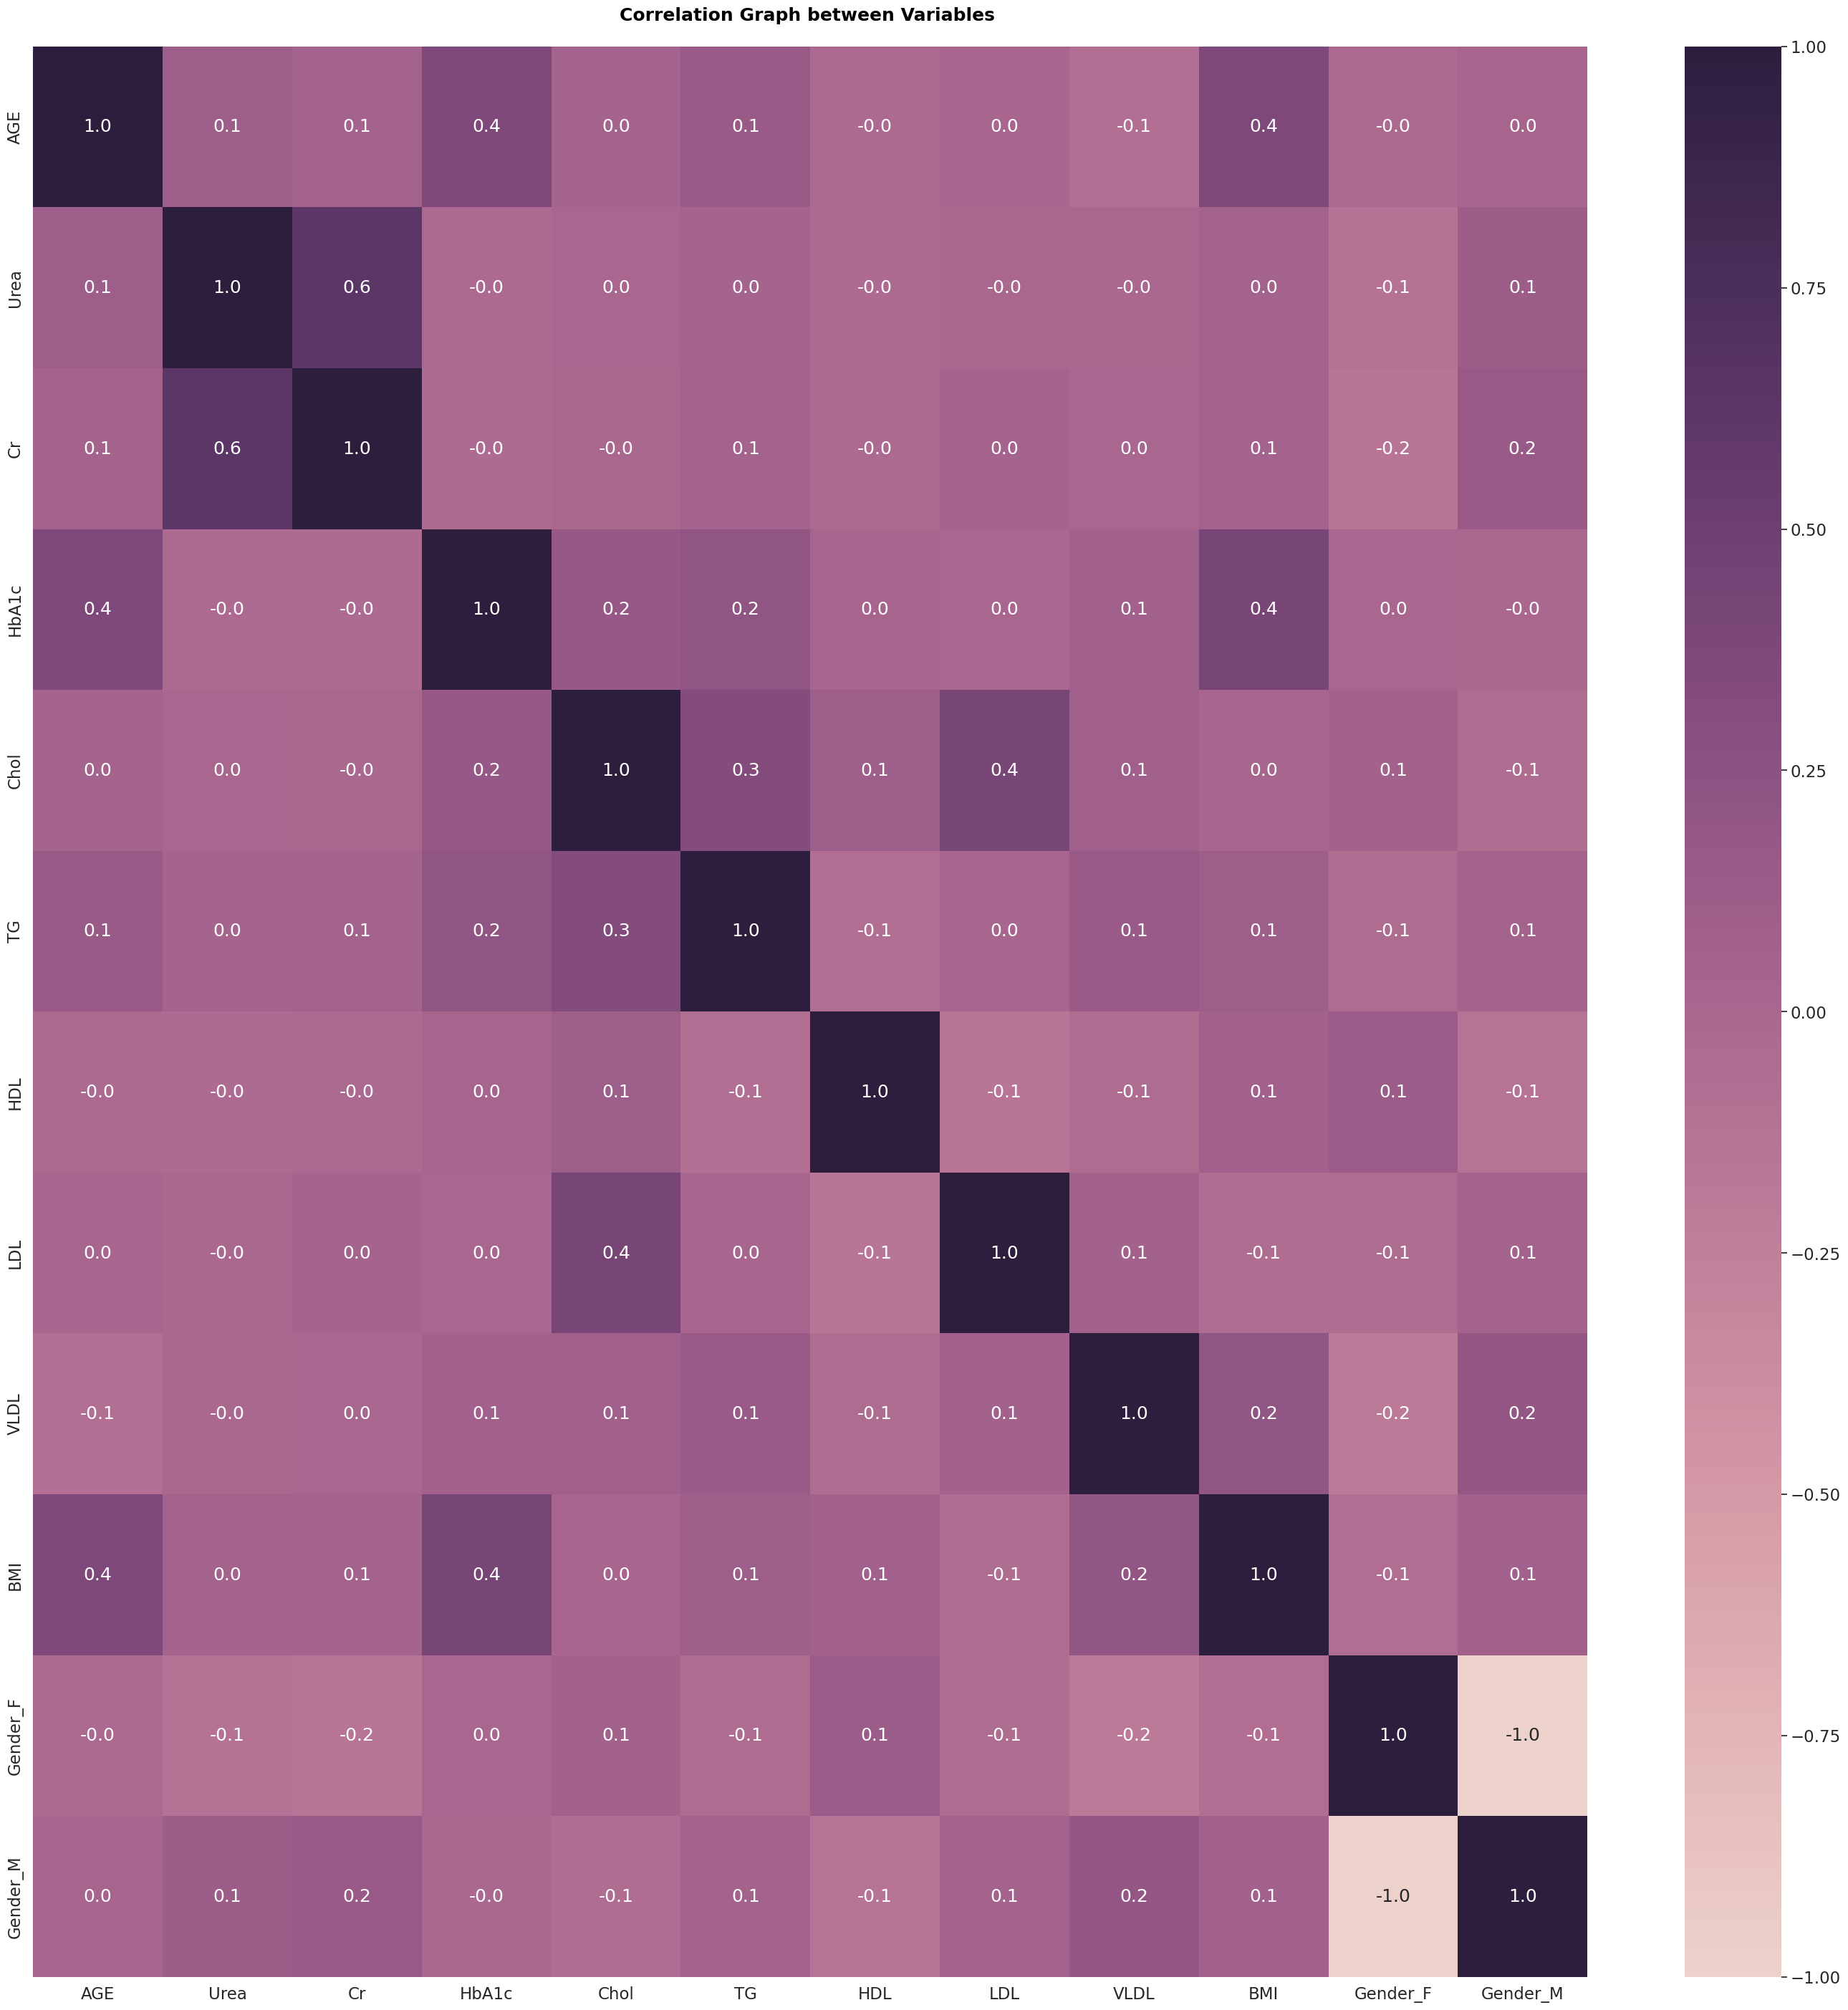

In [100]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Plot heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

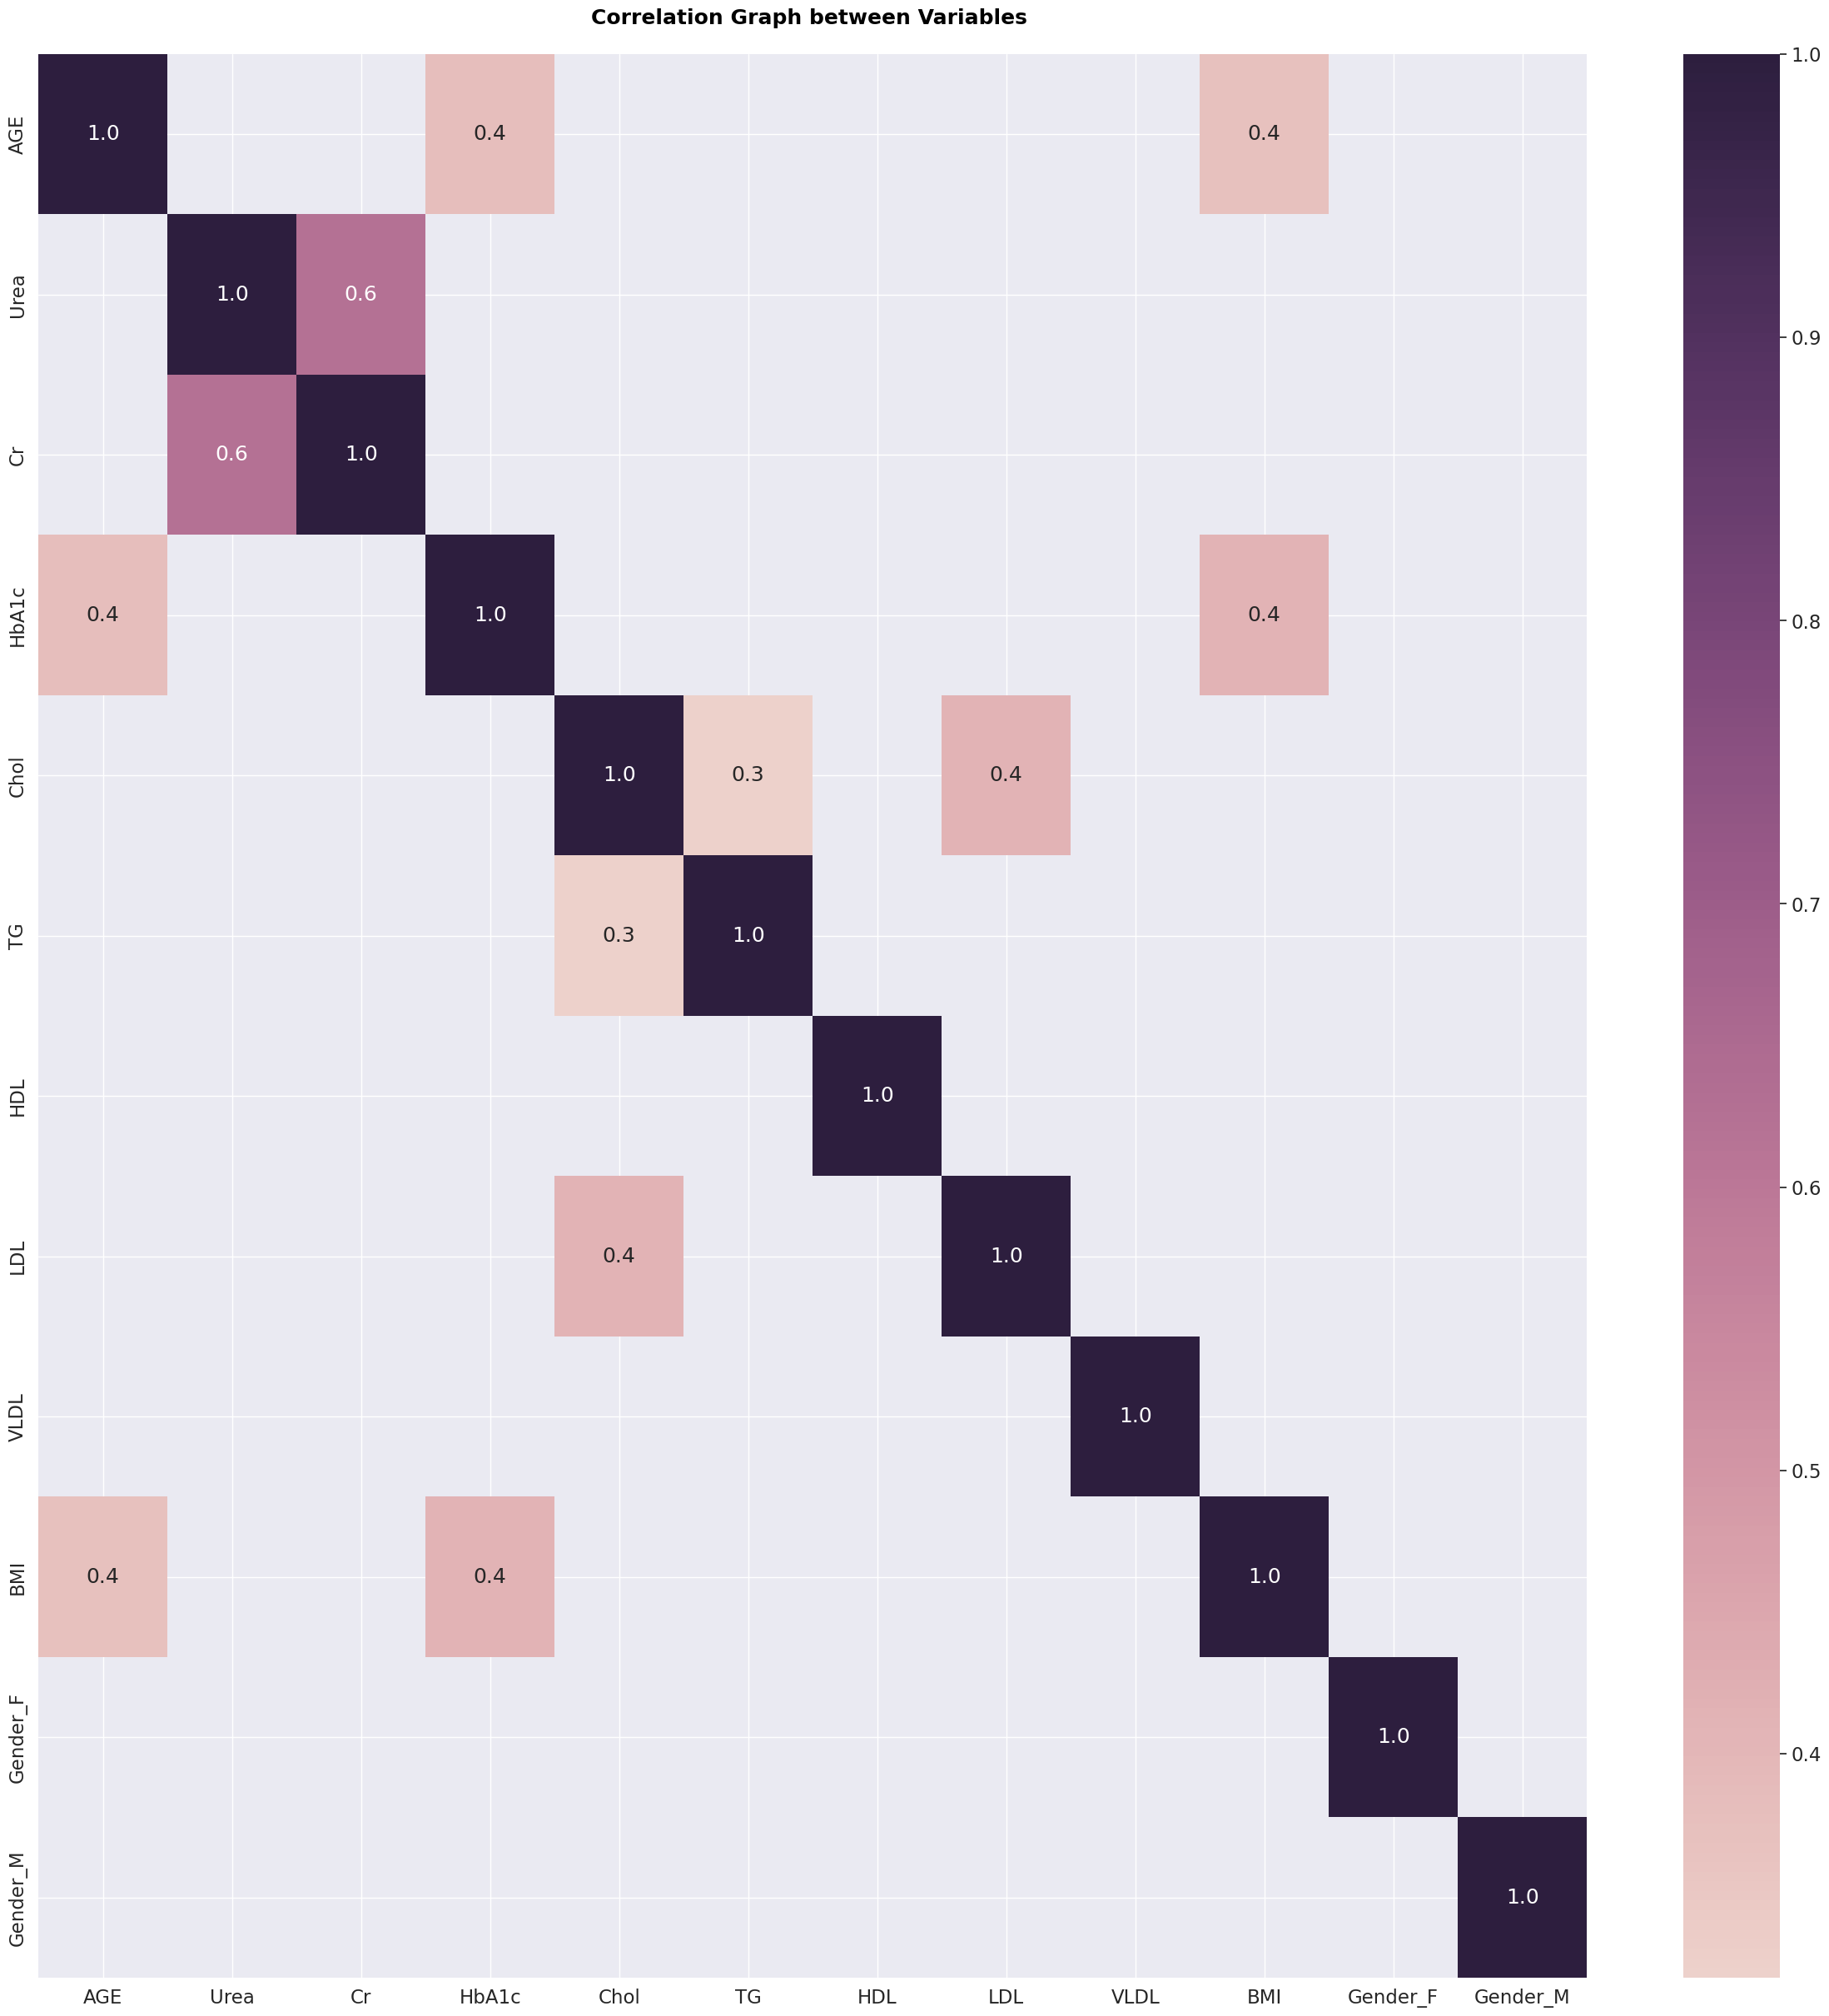

In [101]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.25], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

In [102]:
import plotly.express as px
# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
# Extract the first column from the 2D array 'y' and assign it to 'target'

X_df['target'] = y  # Assuming you want the first column of 'y'
  # Create the histogram using the DataFrame and color mapping
histogram_diagnosis = px.histogram(
      X_df,
      x='target',
      color=X_df['target'],  # Map target values to colors
      title='Count Cases',
      text_auto=True,
  )
histogram_diagnosis.show()

In [103]:
import plotly.express as px
fig = px.pie(X_df, names='target', title='Percentage',color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

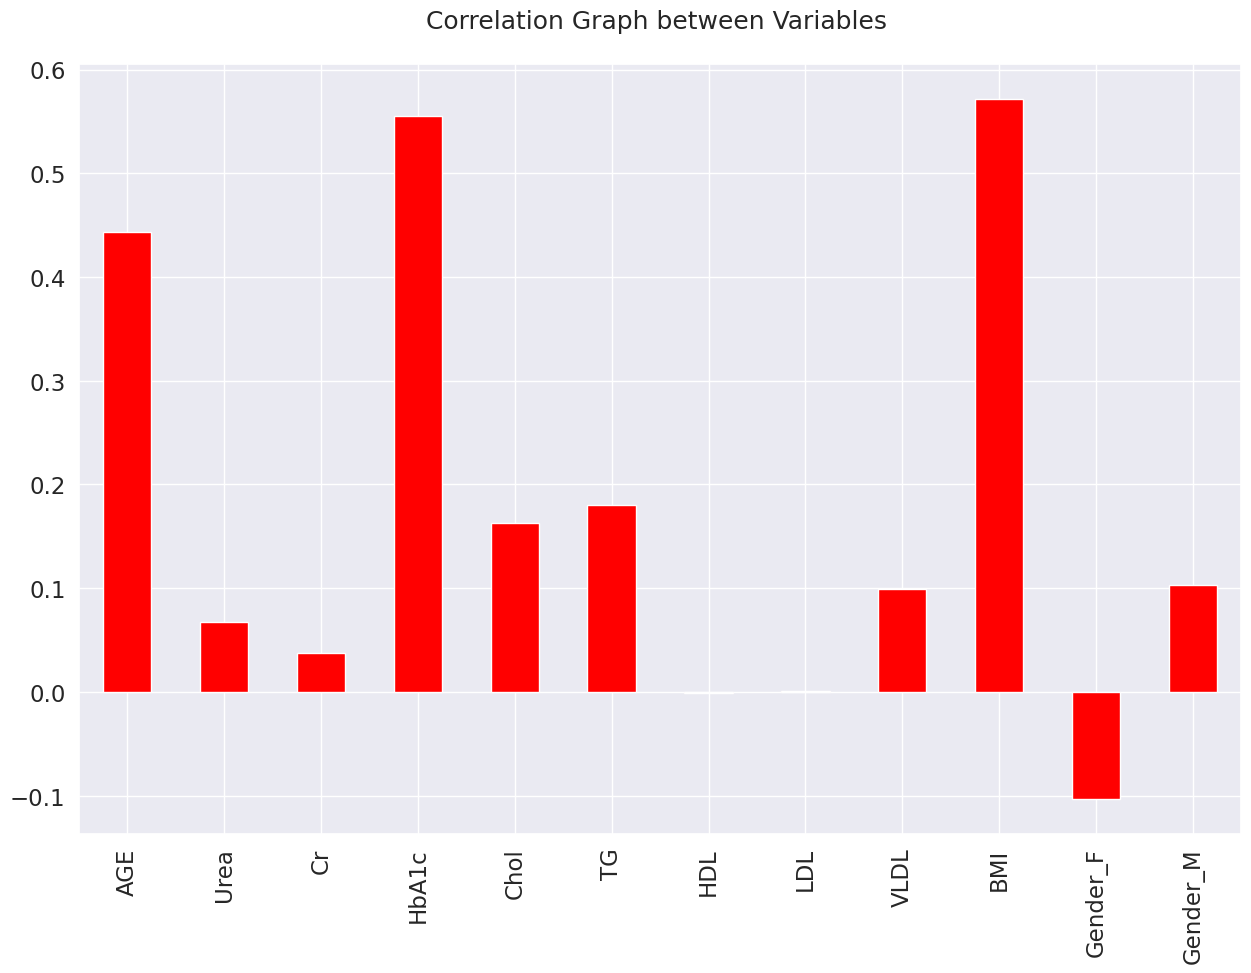

In [104]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

#Model

In [105]:
batch_size=5
epochs=20
clusters=2
tree_model='Random Forest'

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

In [106]:
def encode_target(y, target, num_classes=None):  # Add num_classes argument
    l_encode = LabelEncoder()
    l_encode.fit(y)  # Fit on the actual target values

    # Calculate num_classes if not provided
    if num_classes is None:
        num_classes = len(l_encode.classes_)

    Y = l_encode.transform(y)
    Y = to_categorical(Y, num_classes=num_classes)  # Specify num_classes
    return Y, l_encode  # Return the encoder as well

#Neural Model Multclass

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6321 - loss: 0.9363
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8034 - loss: 0.7097
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8486 - loss: 0.6377
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8225 - loss: 0.6519
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8309 - loss: 0.6046
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8262 - loss: 0.5732
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8376 - loss: 0.5287
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8405 - loss: 0.5068
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8192 - loss: 0.5593
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8249 - loss: 0.4892
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8527 - loss: 0.4345
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

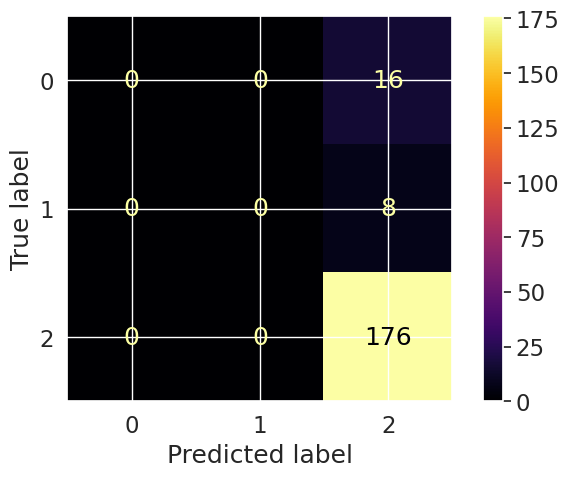

In [107]:
#Neural Network Multclass
# Get the total number of classes from the entire target (y)
all_target_classes = np.unique(np.concatenate([ytrain, ytest]))  # Or use y before splitting
num_classes = len(all_target_classes)

ytrain, l_encode_train = encode_target(ytrain, variavel, num_classes)
ytest, l_encode_test = encode_target(ytest, variavel, num_classes)

processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model_multiclass()

processor_Neuro.models_metrics_neuro_multiclass(model, Xtrain, ytrain, Xtest, ytest,l_encode_train,l_encode_test)

#Decission Tree MultClass

In [108]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

Best Parameter to criterion entropy
Best Parameter to max_depth 5

Model Accuracy: 99.50%

F1 Score: 99.48%

Recall Score:99.50%



Confussion Matrix


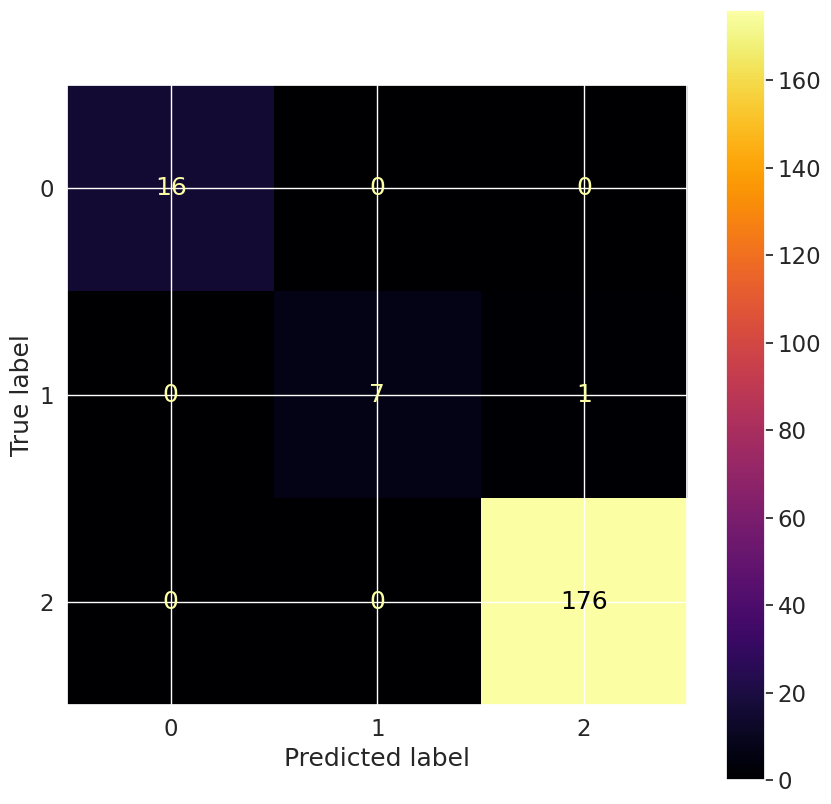


 Feature Importance
importance    12
dtype: int64


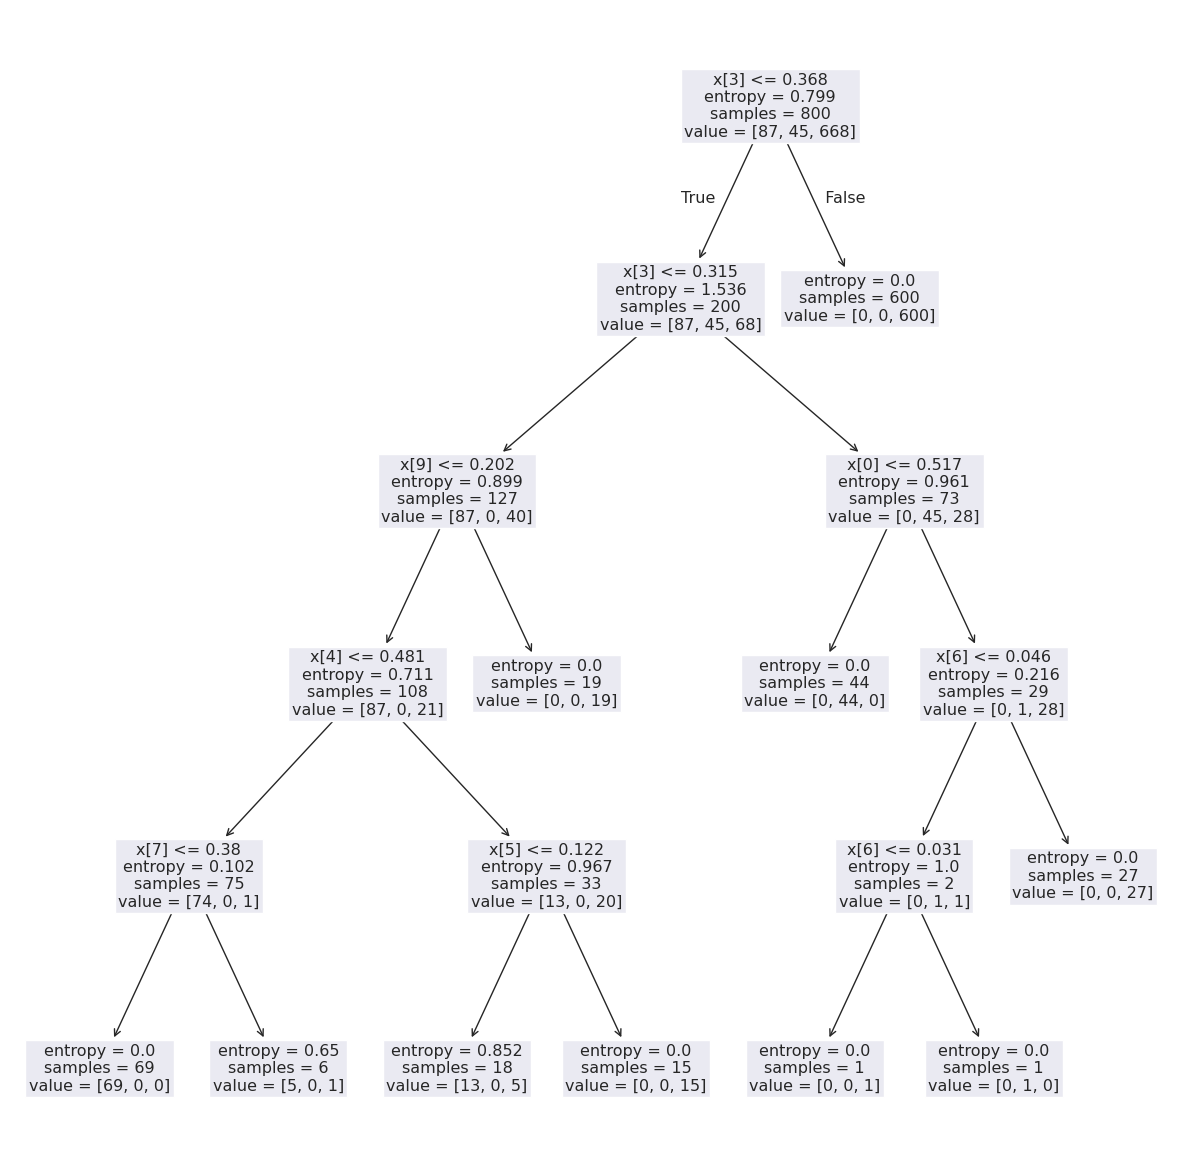

In [109]:
#Decission Tree
type_model='Decission Tree'
processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
processor_decission_tree.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


#Random Forest MultClass Model

Best Parameter to n_estimators 20
Best Parameter to max_depth 4

Model Accuracy: 97.00%

F1 Score: 96.70%

Recall Score:97.00%



Confussion Matrix


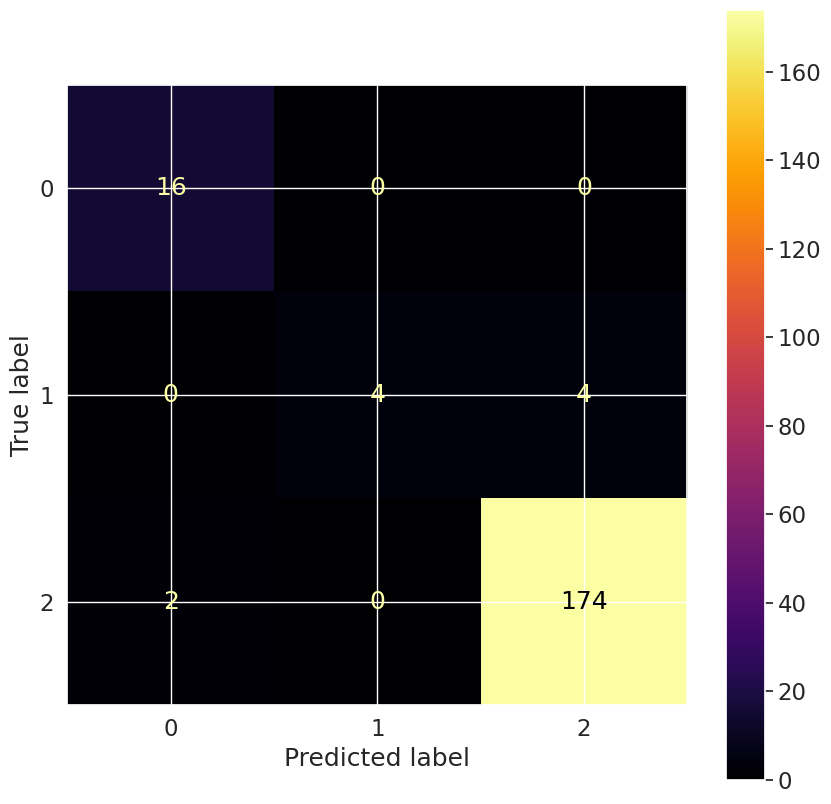


 Feature Importance
importance    12
dtype: int64


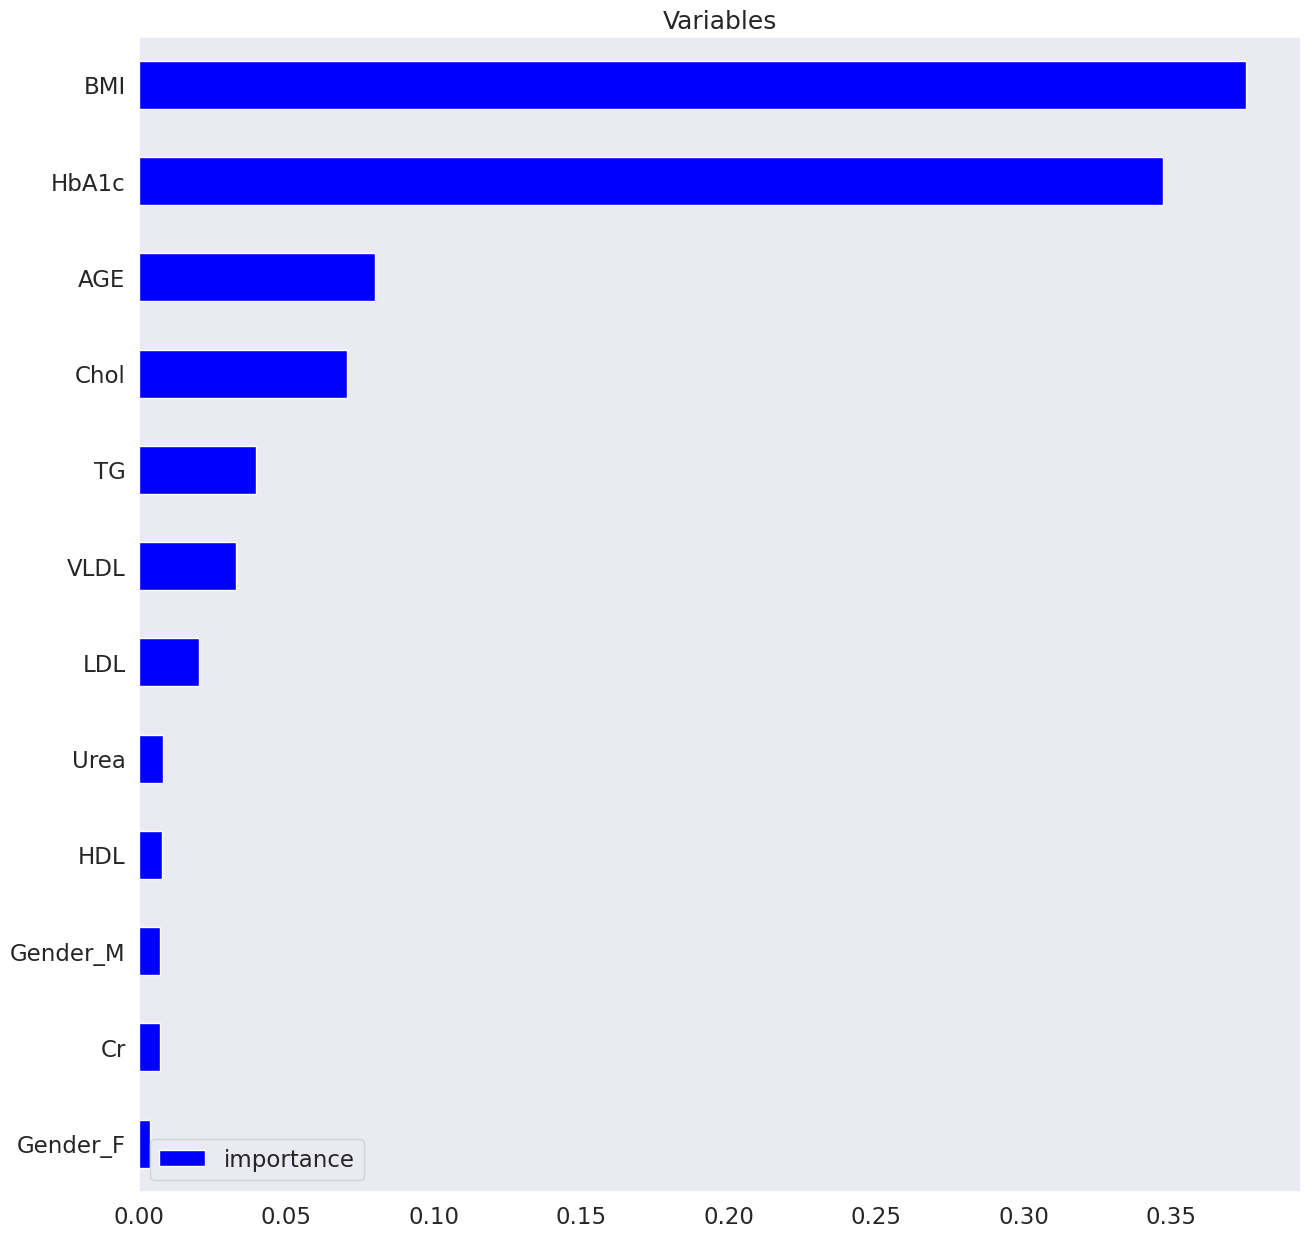

In [110]:
#Random Forest
type_model='Random Forest'
processor_randomf = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)


Best Parameter to n_neighbors 5
Best Parameter to p 1

Model Accuracy: 97.00%

F1 Score: 97.05%

Recall Score:97.00%



Confussion Matrix


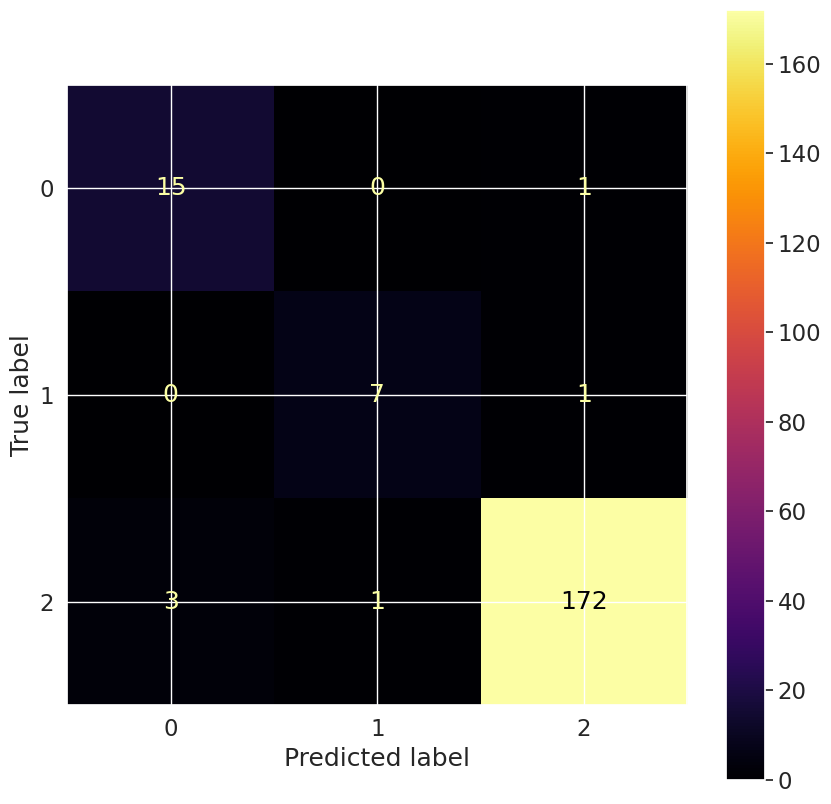


 KNN model does not have feature importance


In [111]:
#KNN Model
type_model='KNN'
processor_knn = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_knn.knn_model()
processor_knn.metrics_class(model, Xtrain, ytrain, Xtest, ytest,type_model)

#To predict new data sets, the database of interest must undergo the same transformation methods that were used in the development of the model.

In [ ]:
#Load  The New Dataset
Dataset=pd.read_csv('New_data.csv',sep=';')

In [ ]:
#Processing Variables

list_to_drop=['ID','No_Pation']
#list_to_drop_percentage=percent_missing[percent_missing > 20].index
#Dataset.drop(list_to_drop_percentage,axis=1,inplace=True)
Dataset.drop(list_to_drop,axis=1,inplace=True)

processor = processing_data(base=Dataset.copy())
variavel='CLASS'
target='Y'
type_method='mean'
dummies=list(Dataset.select_dtypes(include=['object']).columns)
dummies.remove('CLASS')
#var_int=['Tumor Purity']
multiclass=True
#str_var=['hg','ap']

In [ ]:
#Using pipelines we can apply modification in my data, to a better use in my model
main_pipeline=Pipeline([
                        #('int_values', FunctionTransformer(processor.int_values,
                        #                    kw_args={'str_var': var_int},
                        #                    validate=False)),
                        #('float_values', FunctionTransformer(processor.float_values,kw_args={'str_var': str_var},
                        #                                     validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': variavel, 'target':target, 'multiclass':multiclass},
                                            validate=False)),
                        ('Dummies', FunctionTransformer(processor.dummy_df,
                                            kw_args={'dummies': dummies},
                                            validate=False)),
                        ])

# Fit and transform the data using the pipeline
transformed_data = main_pipeline.fit_transform(Dataset)
X=processor.impute_values(transformed_data,type_method)
X,y,Lista_variaveis=processor.normalize_df(X,variavel)

In [ ]:
#In the end we can build a base with the new information and the predicted value.
pred = model.predict(X)
X11 = processor.min_max_scaler.inverse_transform(Xtest)
df = pd.DataFrame(data=X11, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y_pred,columns=['Pred'])
df3 = pd.concat([df,df2],axis=1)

In [ ]:
df3.to_csv('new_base_predict.csv', index=False)